In [1]:
# Import necessary libraries
# =====================================================================
import os

# Configurar el nivel de logging para mostrar solo errores
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf
import pandas as pd

# Import src code
from src.model.model_build import *
from src.utils.utils import PROJECT_DIR, DATA_PATH
from src.visualization import visualize
from src.model.overfitting_test import *
from src.data.create_dataset import dataset_tf
from src.data.path_loader import PathLoader

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 64
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 32
EPOCHS = 100
T = 500
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

# 1. Dataset

- The shape of the dataset is: (32, 64, 64, 3) => batch_size: 32, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (32, 18) => batch_size: 32, number of labels: 18


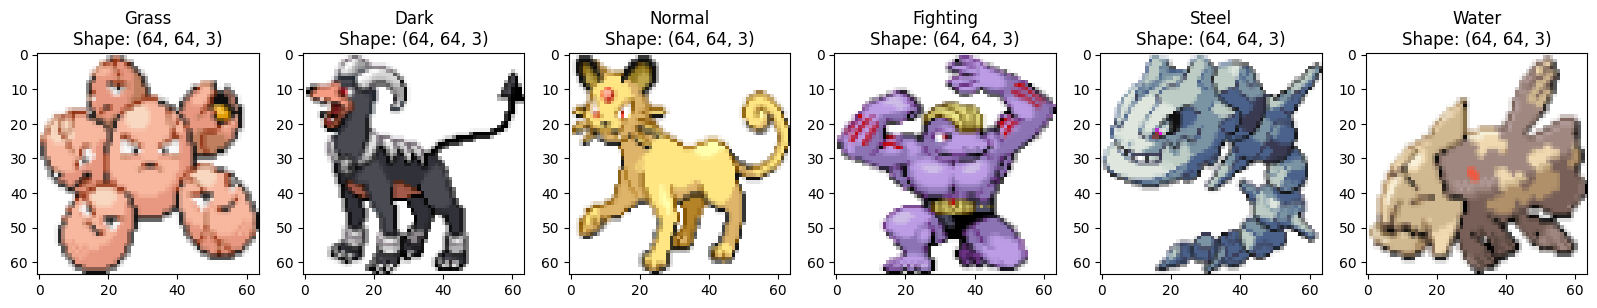

In [4]:
# Load csv data
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
# poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

poke_dataset = dataset_tf(
    image_paths=PathLoader.get_image_paths(f"{DATA_PATH}/interim/image_paths.json"),
    df=df,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    save=False,
    save_path=dataset_path,
)

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

# 2. Model

In [6]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES, num_channels=128, embedding_dim=128)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, "linear"
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

## 2.1. Training

In [7]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 20)])

Epoch 1/100


I0000 00:00:1715271810.702386    3077 service.cc:145] XLA service 0x730930003150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715271810.702409    3077 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
W0000 00:00:1715271811.253433    3077 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform
I0000 00:00:1715271813.283500    3204 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_9', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1715271813.560585    3212 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_9', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1715271814.872653    3210 asm_compiler.cc:369] ptxas warning : R

104/127 ━━━━━━━━━━━━━━━━━━━━ 7s 327ms/step - loss: 0.6792

In [ ]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=500, callbacks=[DiffusionCallback(model, 20)])

In [ ]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=500, callbacks=[DiffusionCallback(model, 20)])

Generating sample 1/1


Sampling sprite: 500it [00:27, 18.20it/s]                         


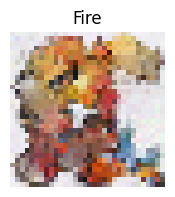

Generating sample 1/1


Sampling sprite: 500it [00:26, 18.57it/s]                         


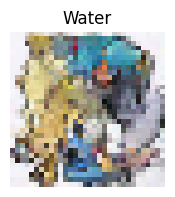

Generating sample 1/1


Sampling sprite: 500it [00:27, 18.49it/s]                         


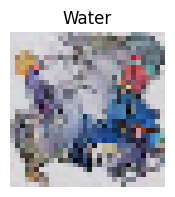

Generating sample 1/1


Sampling sprite: 500it [00:26, 18.58it/s]                         


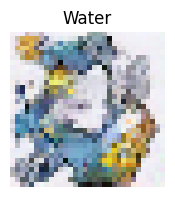

Generating sample 1/1


Sampling sprite: 500it [00:27, 18.48it/s]                         


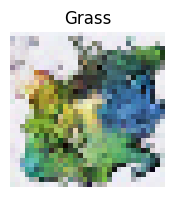

Generating sample 1/1


Sampling sprite: 500it [00:26, 18.66it/s]                         


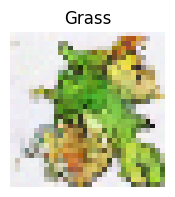

Generating sample 1/1


Sampling sprite: 500it [00:26, 18.64it/s]                         


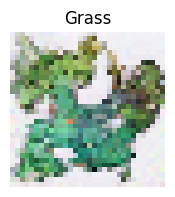

Generating sample 1/1


Sampling sprite: 500it [00:26, 18.57it/s]                         


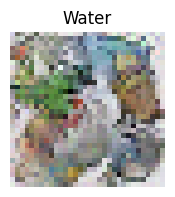

Generating sample 1/1


Sampling sprite: 500it [00:27, 18.48it/s]                         


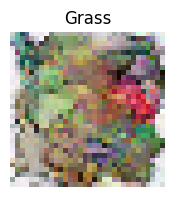

In [18]:
model.plot_samples(6, "Fire")
model.plot_samples(6, "Water")
model.plot_samples(6, "Grass")

Generating sample 1/1


Sampling sprite: 500it [00:28, 17.83it/s]                         


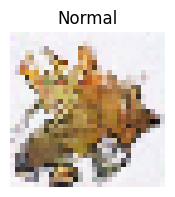

Generating sample 1/1


Sampling sprite: 500it [00:28, 17.46it/s]                         


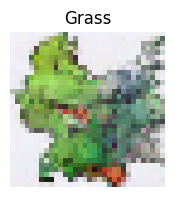

Generating sample 1/1


Sampling sprite: 500it [00:28, 17.75it/s]                         


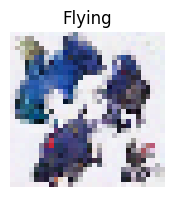

Generating sample 1/1


Sampling sprite: 500it [00:28, 17.52it/s]                         


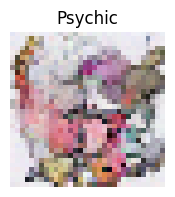

Generating sample 1/1


Sampling sprite: 500it [00:28, 17.76it/s]                         


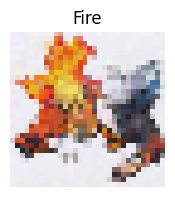

Generating sample 1/1


Sampling sprite: 500it [00:28, 17.73it/s]                         


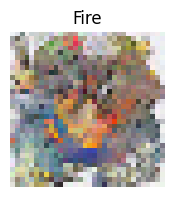

Generating sample 1/1


Sampling sprite: 500it [00:27, 18.24it/s]                         


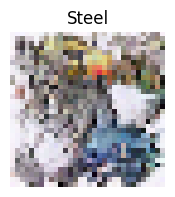

Generating sample 1/1


Sampling sprite: 500it [00:26, 18.55it/s]                         


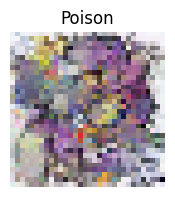

Generating sample 1/1


Sampling sprite: 500it [00:27, 18.43it/s]                         


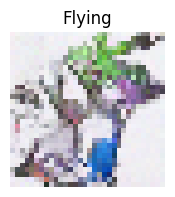

Generating sample 1/1


Sampling sprite: 500it [00:27, 18.44it/s]                         


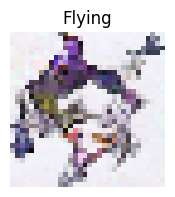

In [17]:
for i in range(10):
    model.plot_samples(1)

## 2.2. Save Model

Finalmente, se guardan los resultados finales del modelo de difusión en un fichero `.h5` para su posterior uso y visualización. TODO: MIRAR OTROS FORMATOS DE GUARDADO

TODO: INVESTIGAR OTROS FORMATOS DE GUARDADO (HDF5, PICKLE, ETC.)

In [12]:
# Save the model function
# =====================================================================
def save_model(model: tf.keras.models.Model, model_name: str) -> None:
    """Saves the model

    :param model: The model to save
    :param model_name: The name of the model
    :return: None
    """

    # Save the model
    model_dir = "../../models/"
    os.makedirs(model_dir, exist_ok=True)
    if not os.path.exists(os.path.join(model_dir, f"{model_name}.h5")):
        model.save(os.path.join(model_dir, f"{model_name}.keras"))
        print(f"Model {model_name}, saved successfully!")
    else:
        print(f"Model {model_name}, already exists!")

In [13]:
# Save the model
SCHEDULER = "linear"
EPOCHS = 1100
model_name = f"diffusion_{IMG_SIZE}_{BATCH_SIZE}_{EPOCHS}_{T}_{SCHEDULER}_ddpm_attention_time_sin"

save_model(model, model_name)

/home/pqlza/.local/lib/python3.11/site-packages/keras/src/saving/saving_api.py:100: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


Model diffusion_32_64_1100_500_linear_ddpm_attention_time_sin, saved successfully!


In [14]:
# load the model
# =====================================================================
model_loaded = tf.keras.models.load_model(f"../../models/{model_name}.keras")

model_load.plot_samples(6)

TypeError: <class 'src.model.overfitting_test.DiffusionModel'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'src.model.overfitting_test', 'class_name': 'DiffusionModel', 'config': {'trainable': True, 'dtype': 'float32'}, 'registered_name': 'DiffusionModel', 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 9.999999747378752e-05, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': {'module': 'keras.losses', 'class_name': 'MeanSquaredError', 'config': {'name': 'mean_squared_error', 'reduction': 'sum_over_batch_size'}, 'registered_name': None}, 'loss_weights': None, 'metrics': None, 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}.

Exception encountered: Unable to revive model from config. When overriding the `get_config()` method, make sure that the returned config contains all items used as arguments in the  constructor to <class 'src.model.overfitting_test.DiffusionModel'>, which is the default behavior. You can override this default behavior by defining a `from_config(cls, config)` class method to specify how to create an instance of DiffusionModel from its config.

Received config={'trainable': True, 'dtype': 'float32'}

Error encountered during deserialization: DiffusionModel.__init__() got an unexpected keyword argument 'trainable'

[BACK TO TOP](#top)